In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#generate synthetic data

X = np.random.uniform(low=0, high=20, size=(500, 1))

def target(x):
    return x + 3 * np.sin(2*x)

noise = np.random.normal(loc=0, scale=1, size=(500, 1))

Y = target(X) + noise

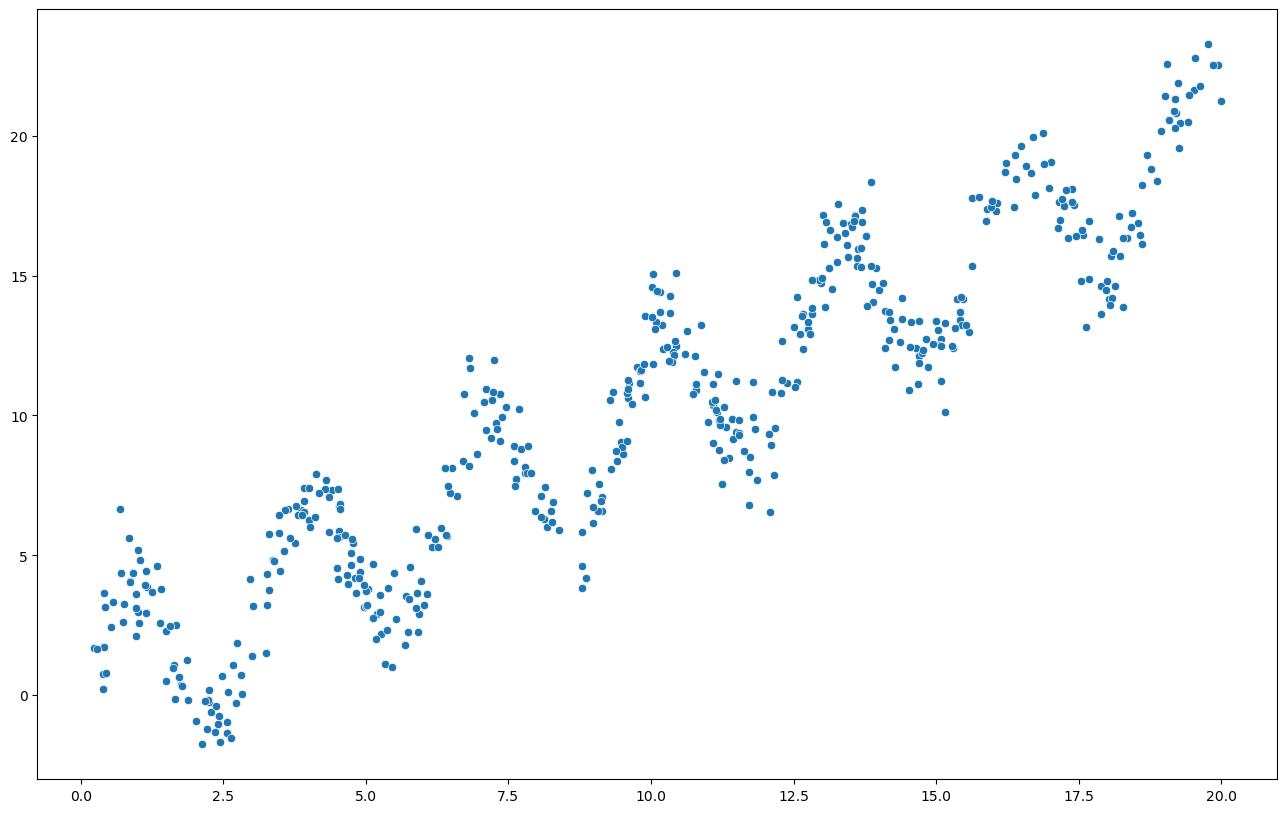

In [3]:
#dependence between x and y

fig = plt.figure()
fig.set_size_inches(16, 10)

sns.scatterplot(x=X.ravel(), y=Y.ravel())

plt.show()

In [4]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

splitter = KFold(n_splits=5, shuffle=True, random_state=33)

linear = LinearRegression()
knn = KNeighborsRegressor(n_neighbors=3)

linear_cv = cross_validate(linear, X, Y, 
                          cv=splitter, scoring='neg_mean_squared_error',
                          return_train_score=True)

knn_cv = cross_validate(knn, X, Y,
                       cv=splitter, scoring='neg_mean_squared_error',
                       return_train_score=True)

In [5]:
print(f"Linear model Mean MSE on train {-np.mean(linear_cv['train_score'])}")
print(f"Linear model Mean MSE on test {-np.mean(linear_cv['test_score'])}")
print(f"KNN model Mean MSE on train {-np.mean(knn_cv['train_score'])}")
print(f"KNN model Mean MSE on test {-np.mean(knn_cv['test_score'])}")

Linear model Mean MSE on train 5.428723230248761
Linear model Mean MSE on test 5.475595761626085
KNN model Mean MSE on train 0.6423432097026625
KNN model Mean MSE on test 1.2865869046798568


In [6]:
# so KNN is better in this case because it works better with nonlinear dependencies

In [7]:
# Lets look at the problem of extrapolation of KNN models

In [8]:
linear.fit(X, Y)
knn.fit(X, Y)

KNeighborsRegressor(n_neighbors=3)

In [9]:
new_X = np.random.uniform(low=20, high=30, size=(50, 1))
new_noise = np.random.normal(loc=0, scale=1, size=(50, 1))

new_Y = target(new_X) + new_noise

knn_preds = knn.predict(new_X)
linear_preds = linear.predict(new_X)

In [10]:
print(f"MSE of KNN model on new data {np.mean((knn_preds - new_Y)**2).round(3)}")
print(f"MSE of Linear model on new data {np.mean((linear_preds - new_Y)**2).round(3)}")

MSE of KNN model on new data 22.935
MSE of Linear model on new data 5.354


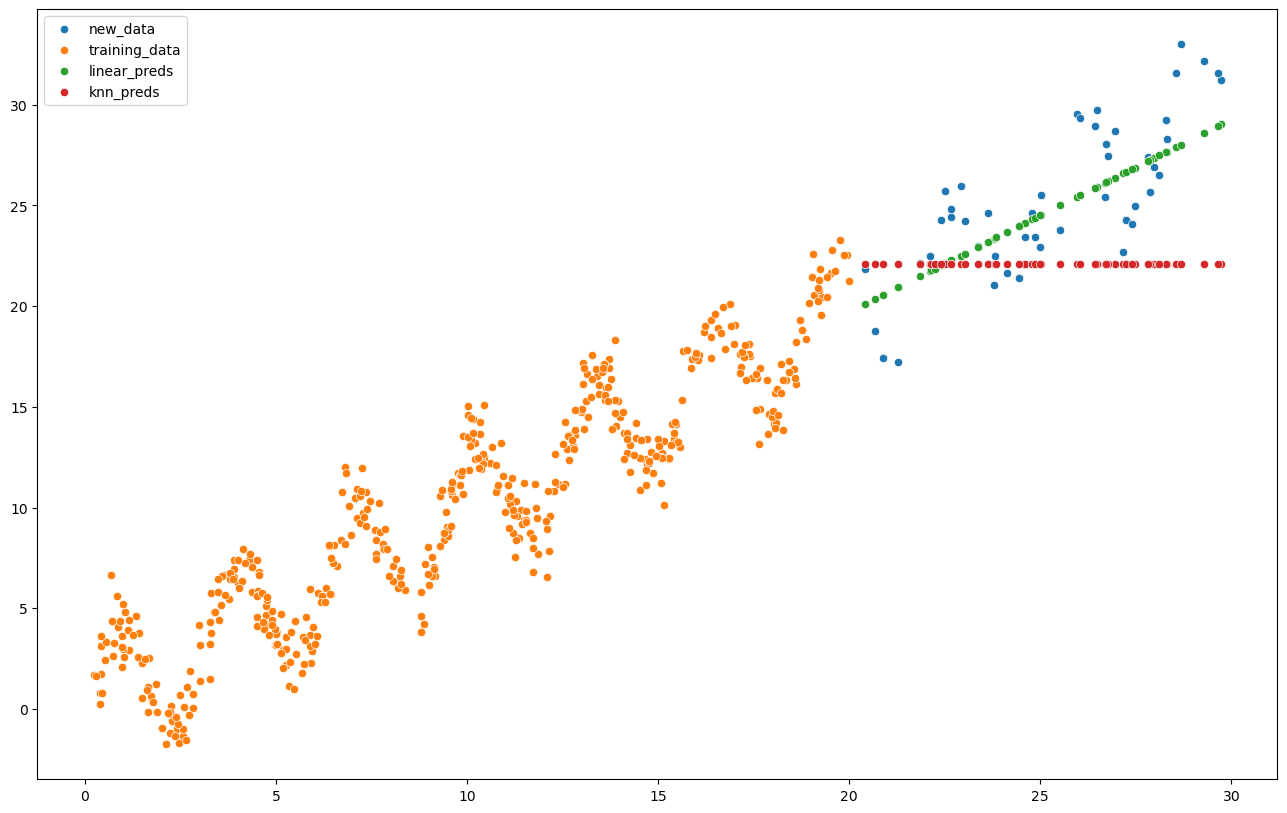

In [11]:
fig = plt.figure()
fig.set_size_inches(16, 10)

sns.scatterplot(x=new_X.ravel(), y=new_Y.ravel())
sns.scatterplot(x=X.ravel(), y=Y.ravel())
sns.scatterplot(x=new_X.ravel(), y=linear_preds.ravel())
sns.scatterplot(x=new_X.ravel(), y=knn_preds.ravel())

plt.legend(["new_data", "training_data", "linear_preds", "knn_preds"])

plt.show()

## hyperparameter (K) selection

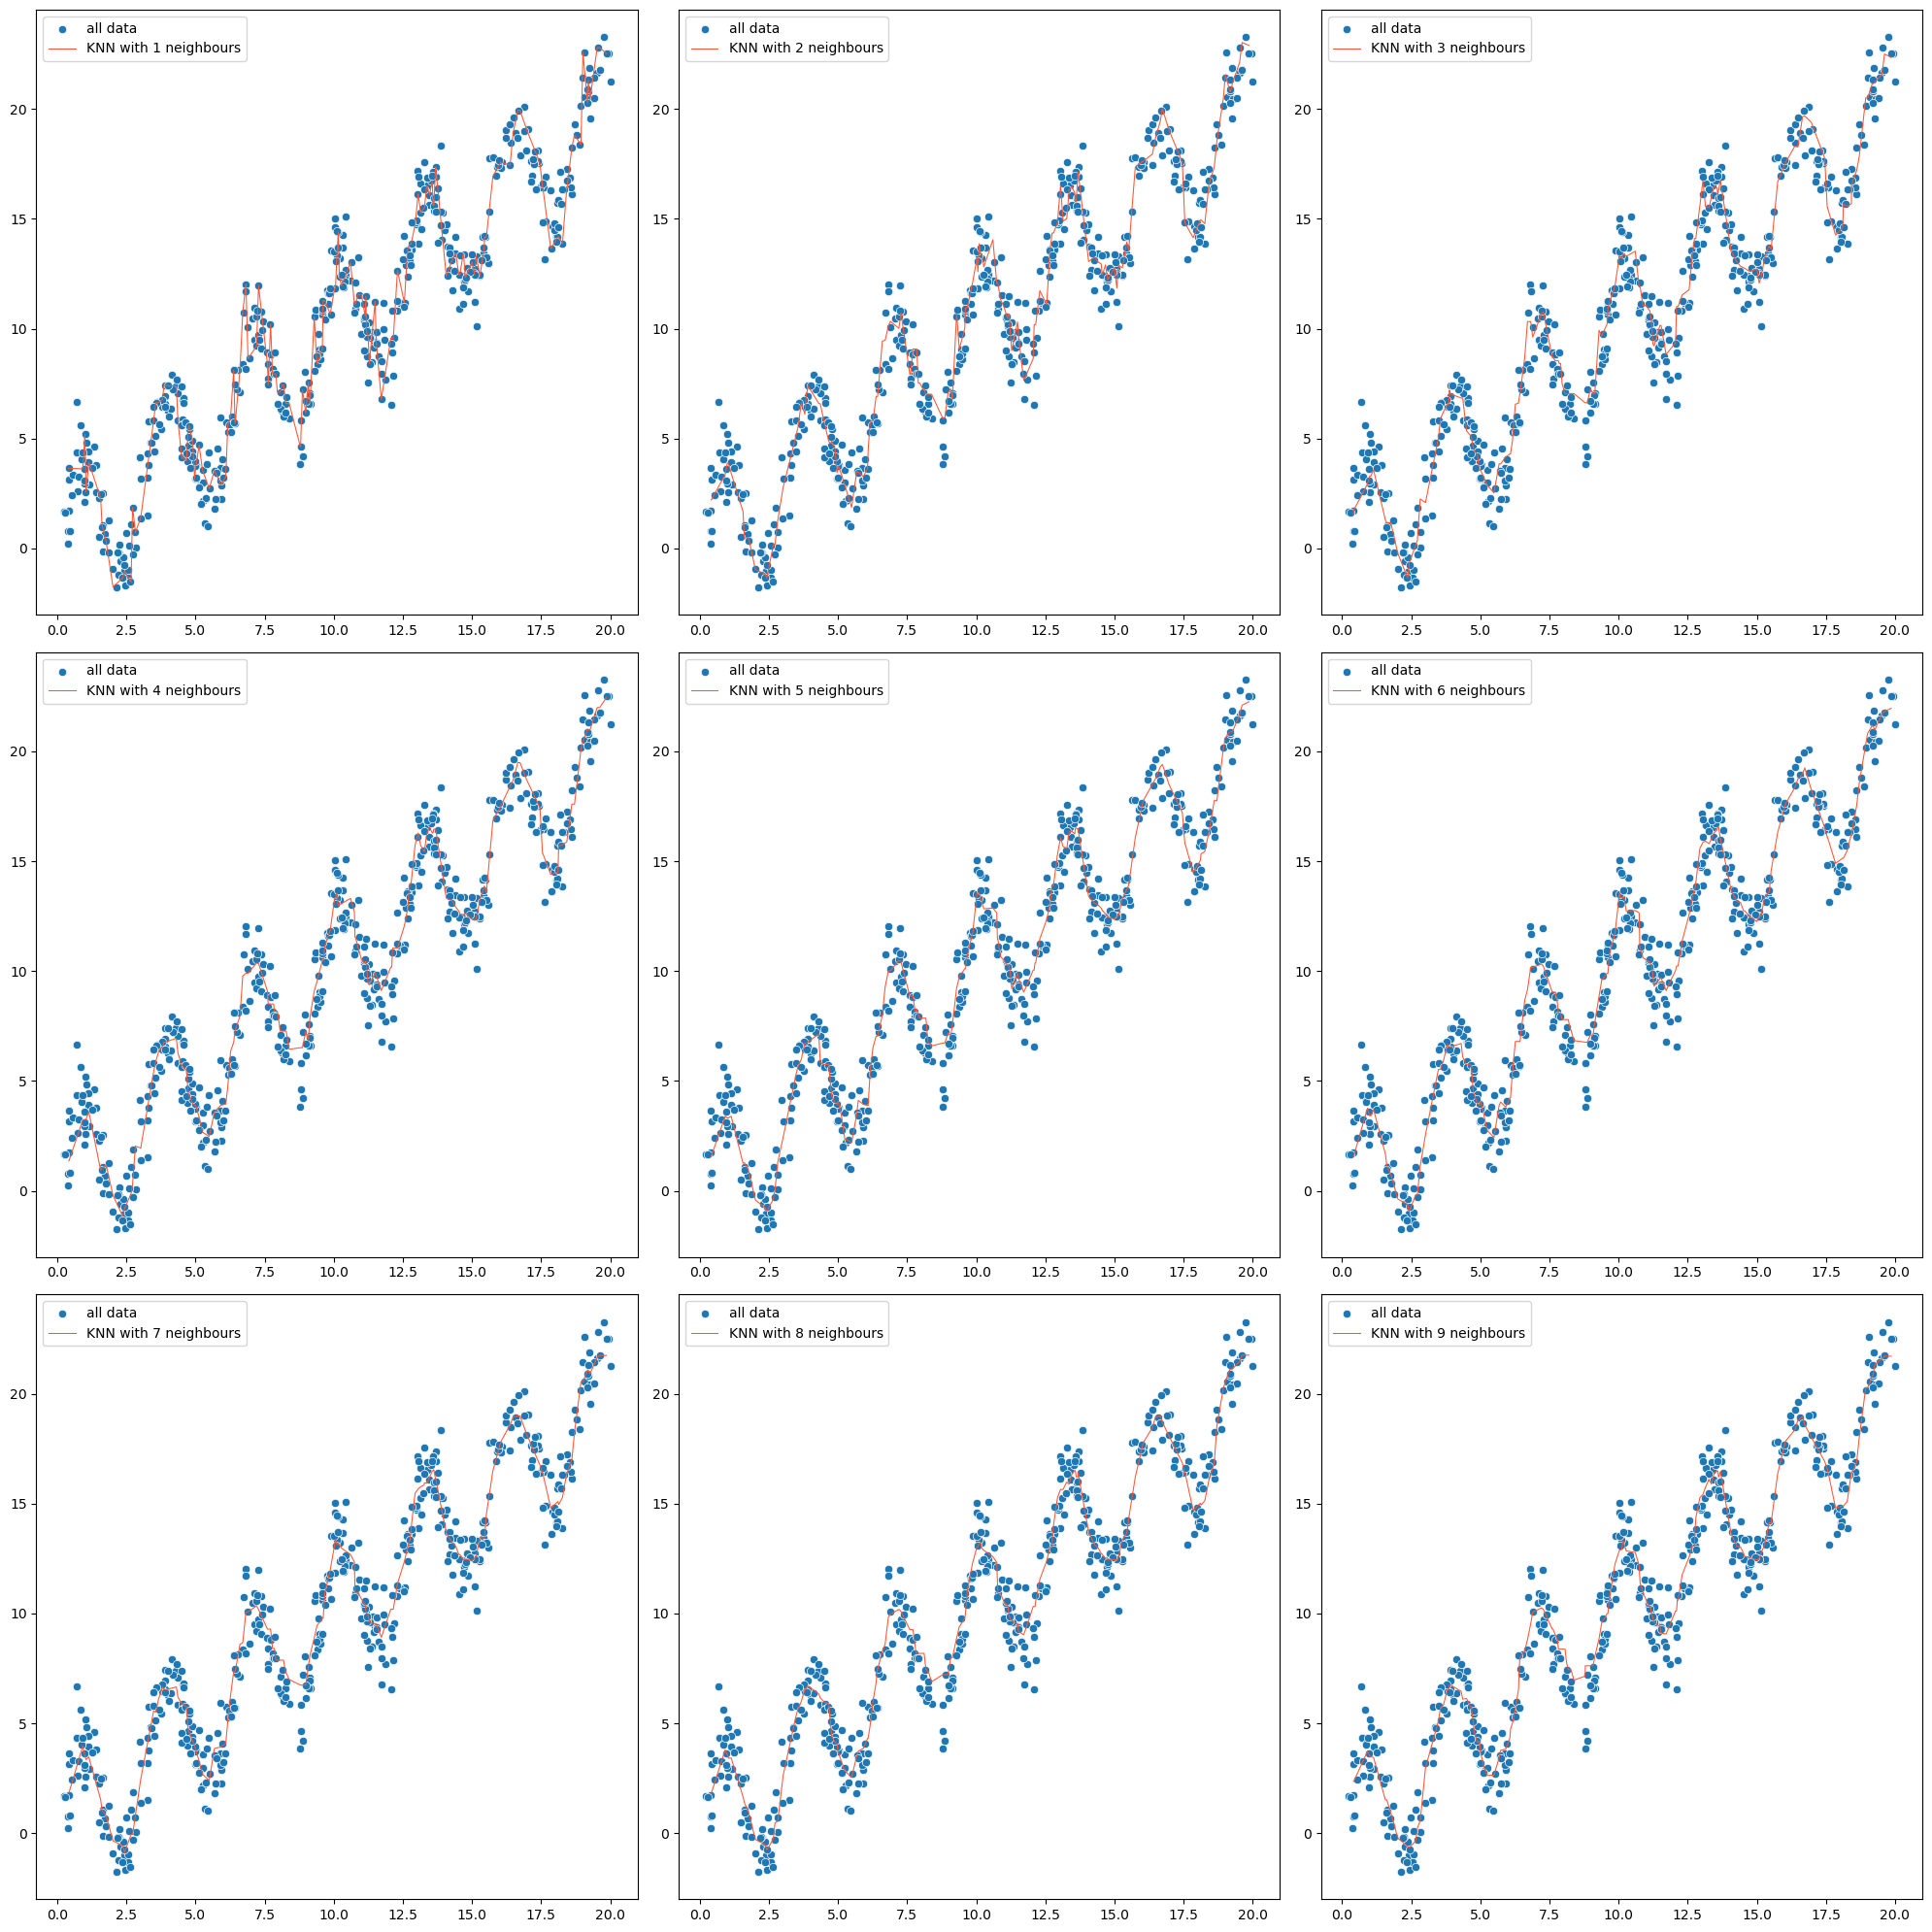

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                   test_size=0.33,
                                                   random_state=33)

fig = plt.figure()
fig.set_size_inches(20, 20)

for K in range(1, 10):
    knn = KNeighborsRegressor(n_neighbors=K)
    knn.fit(X_train, y_train)
    
    preds_test = knn.predict(X_test)
    
    ax = fig.add_subplot(3, 3, K)
    sns.scatterplot(x=X.ravel(), y=Y.ravel())
    sns.lineplot(x=X_test.ravel(), y=preds_test.ravel(), size=10, color='#FF5533')
    plt.legend(["all data", f"KNN with {K} neighbours"])
    
fig.tight_layout()
plt.show()

In [13]:
#Example of underfitting (when the K is too big)

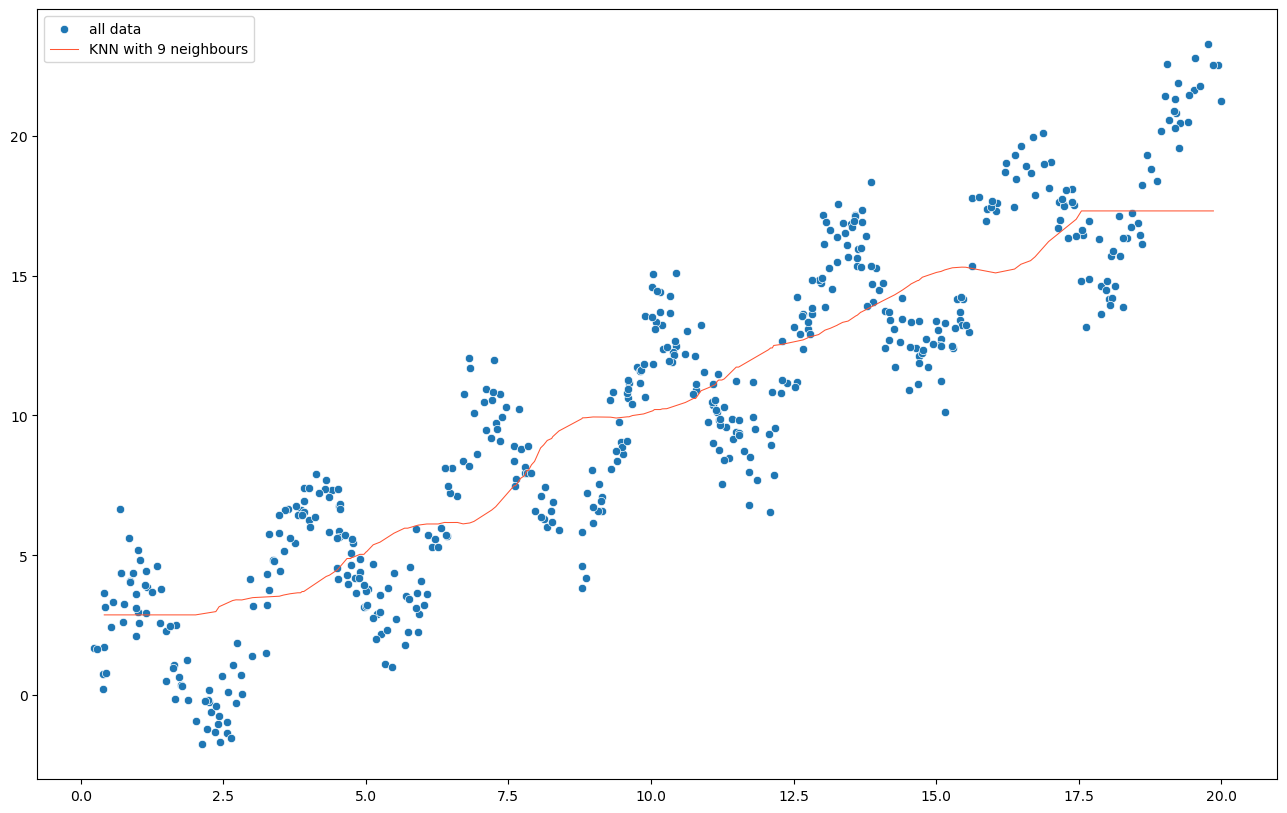

In [14]:
knn = KNeighborsRegressor(n_neighbors=100)

fig = plt.figure()
fig.set_size_inches(16, 10)

knn.fit(X, Y)
preds_test = knn.predict(X_test)

sns.scatterplot(x=X.ravel(), y=Y.ravel())
sns.lineplot(x=X_test.ravel(), y=preds_test.ravel(), size=10, color='#FF5533')
plt.legend(["all data", f"KNN with {K} neighbours"])

plt.show()

In [15]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

search = GridSearchCV(knn, param_grid, cv=splitter)

search.fit(X, Y)

print(search.best_params_)

{'n_neighbors': 10}


Gaussian kernel width

$$
w_i = \frac{1}{\sqrt{2\cdot\pi}} \cdot exp(-\frac{1}{2}\cdot \frac{\rho^2 (x, x_i)}{h^2})
$$

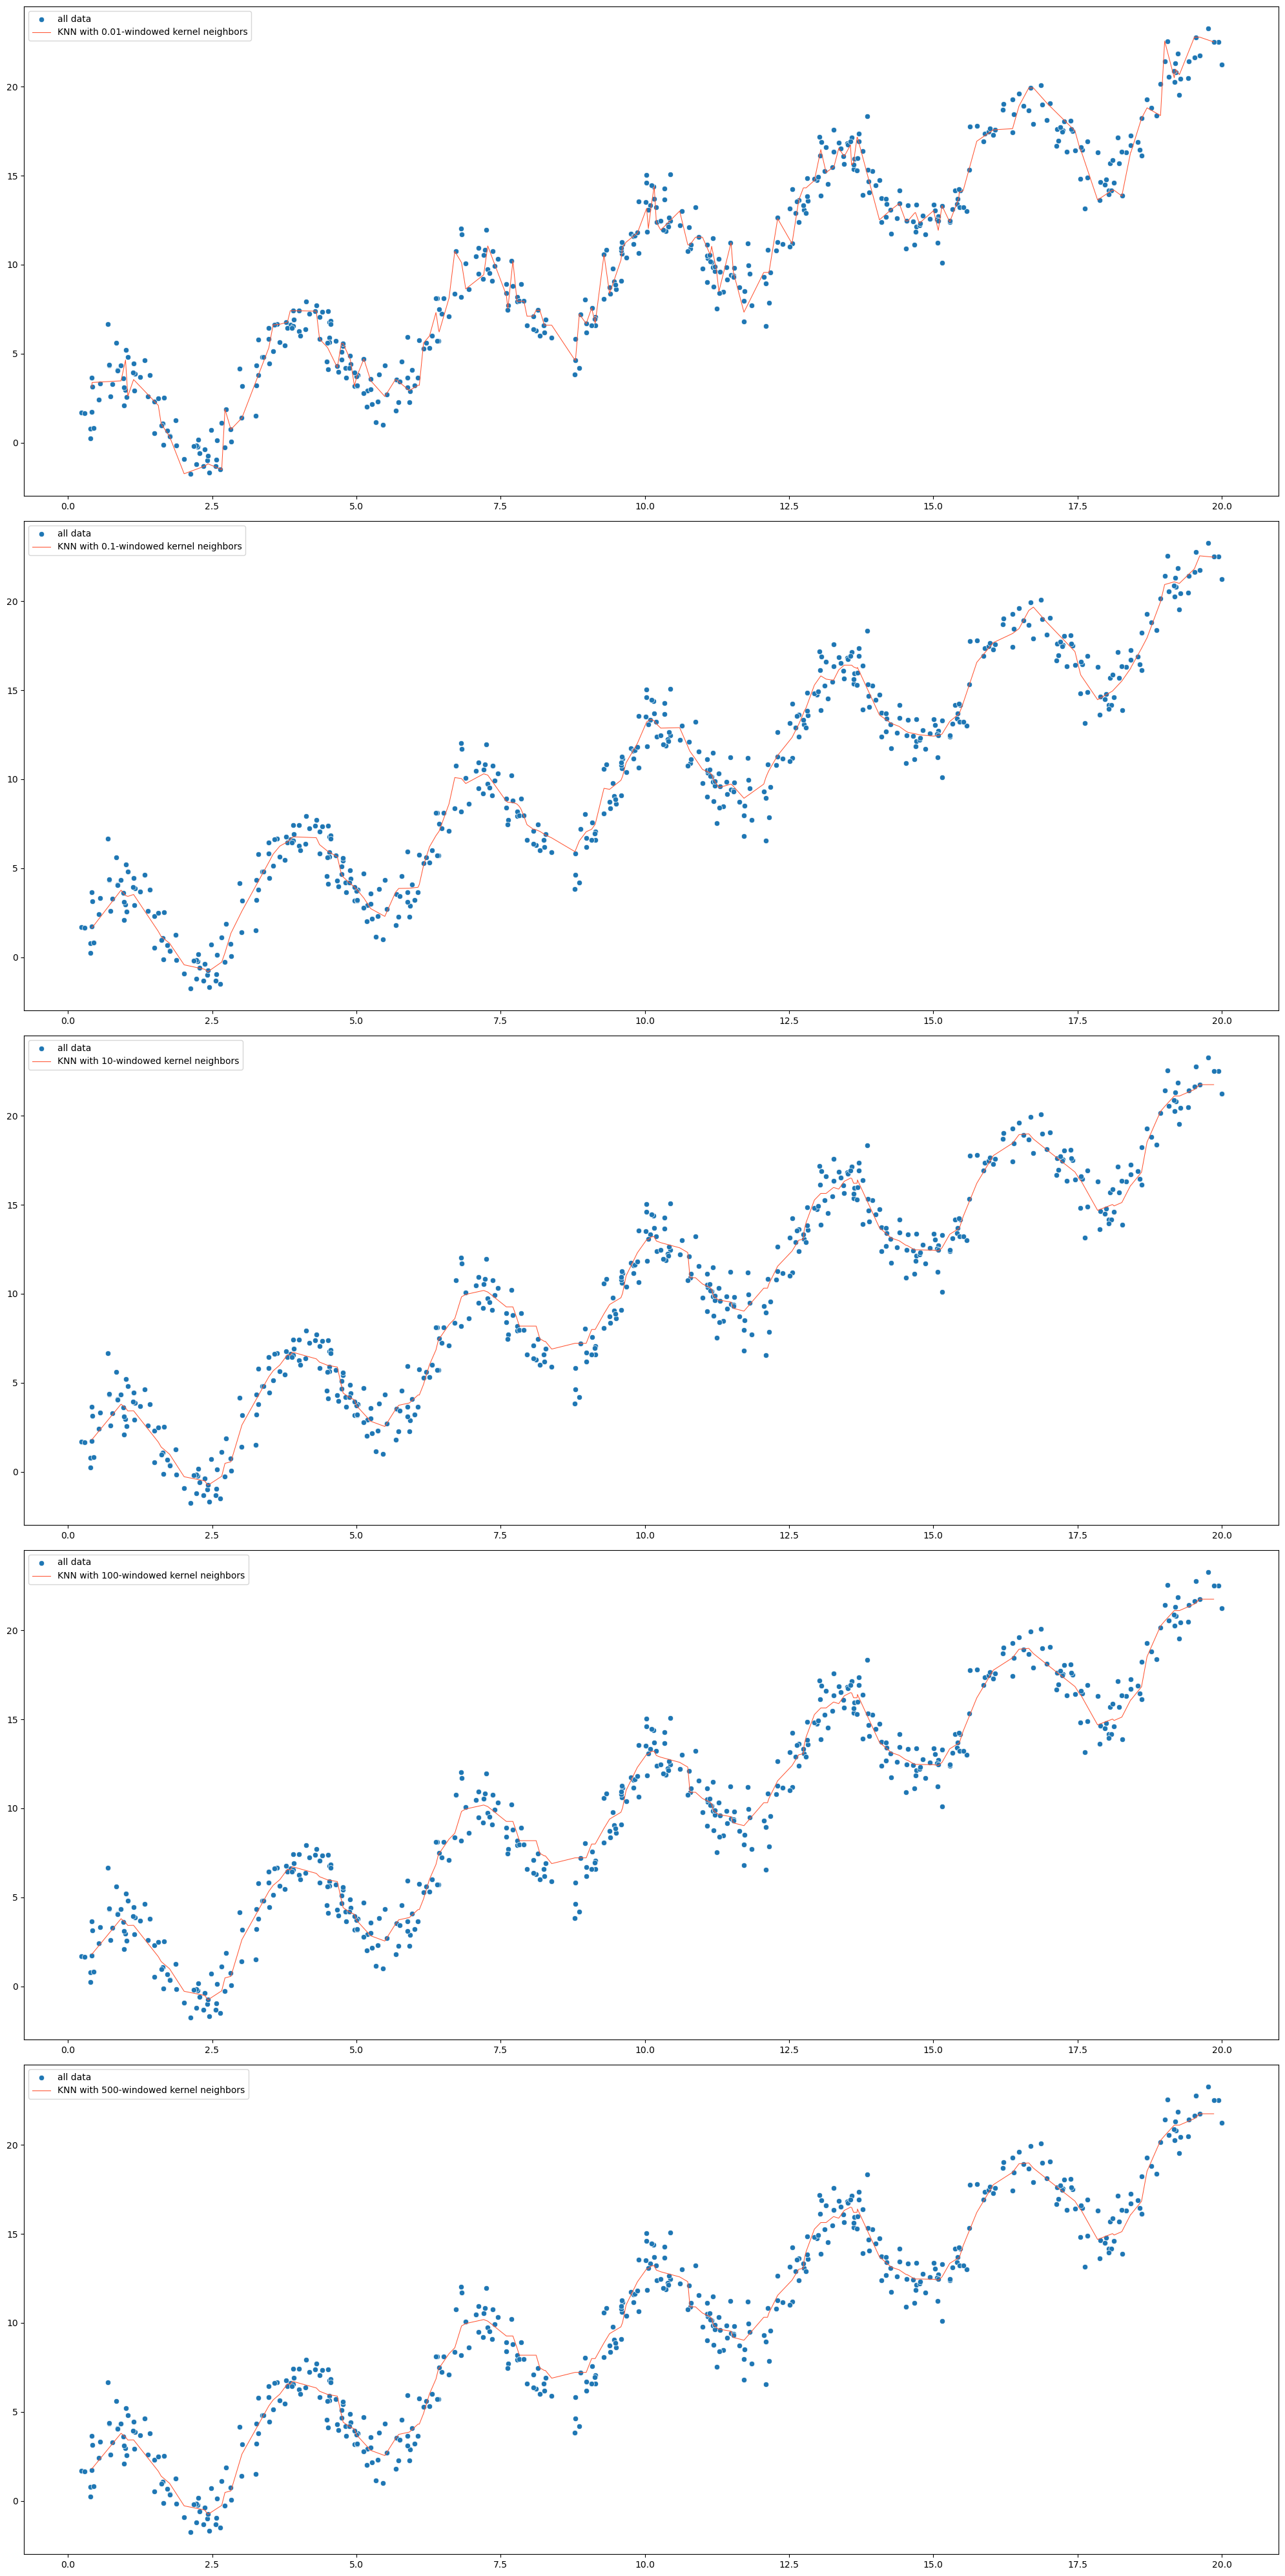

In [16]:
fig = plt.figure()
fig.set_size_inches(20, 40)

k = 1

for h in [0.01, 0.1, 10, 100, 500]:
    
    def kernel(distances, h=h):
        const = 1 / (np.sqrt(2 * np.pi))
        power = (-1/2) * ((distances)**2) / h**2
        return const * np.exp(power)
    
    knn = KNeighborsRegressor(n_neighbors=8, weights=kernel)
    knn.fit(X_train, y_train)
    
    preds_test = knn.predict(X_test)
    
    ax = fig.add_subplot(5, 1, k)
    k += 1
    
    sns.scatterplot(x=X.ravel(), y=Y.ravel())
    sns.lineplot(x=X_test.ravel(), y=preds_test.ravel(), size=10, color='#FF5533')
    plt.legend(["all data", f"KNN with {h}-windowed kernel neighbors"])
    
fig.tight_layout()

# Customers segmentation with KNN

In [17]:
data = pd.read_excel('processed_segmentation.xlsx')

In [18]:
data.head()

,Age,Work_Experience,Family_Size,Segmentation,Gender_Male,Ever_Married_Yes,Graduated_Yes,Profession_B,Profession_C,Profession_D,Spending_Score_High,Spending_Score_Low,Var_1_B,Var_1_C,Var_1_D
0,22,1.000000,4.0,D,1,0,0,0.075826,0.109610,0.734985,0,1,0.213039,0.100092,0.381084
1,38,2.641663,3.0,A,0,1,1,0.270386,0.107296,0.251788,0,0,0.213039,0.100092,0.381084
2,67,1.000000,1.0,B,0,1,1,0.270386,0.107296,0.251788,0,1,0.234287,0.285472,0.248400
3,67,0.000000,2.0,B,1,1,1,0.253612,0.224719,0.205457,1,0,0.234287,0.285472,0.248400
4,40,2.641663,6.0,A,0,1,1,0.232877,0.155954,0.226554,1,0,0.234287,0.285472,0.248400


In [19]:
#Gaussian kernel function

def kernel(distances, h=1):
    
    const = 1 / (np.sqrt(2 * np.pi))
    power = (-1/2) * ((distances)**2) / h**2
    
    return const * np.exp(power)

In [20]:
X = data.drop("Segmentation", axis=1)
Y = data["Segmentation"]

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=0.2)

pipe = Pipeline([("scaler", StandardScaler()),
                ("KNN", KNeighborsClassifier(weights=kernel))])

pipe.fit(X_train, Y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('KNN',
                 KNeighborsClassifier(weights=<function kernel at 0x0000024621299360>))])

In [22]:
print(f"Accuracy on train {np.mean(pipe.predict(X_train) == Y_train ).round(3)}")
print(f"Accuracy on tets {np.mean(pipe.predict(X_test) == Y_test ).round(3)}")

Accuracy on train 0.741
Accuracy on tets 0.487


In [23]:
# Let's try to work with hyperparameters

In [24]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('KNN',
   KNeighborsClassifier(weights=<function kernel at 0x0000024621299360>))],
 'verbose': False,
 'scaler': StandardScaler(),
 'KNN': KNeighborsClassifier(weights=<function kernel at 0x0000024621299360>),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'KNN__algorithm': 'auto',
 'KNN__leaf_size': 30,
 'KNN__metric': 'minkowski',
 'KNN__metric_params': None,
 'KNN__n_jobs': None,
 'KNN__n_neighbors': 5,
 'KNN__p': 2,
 'KNN__weights': <function __main__.kernel(distances, h=1)>}

In [25]:
np.linspace(1, 5, 5, dtype=int)

array([1, 2, 3, 4, 5])

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {"KNN__n_neighbors": np.linspace(1, 100, 10, dtype=int),
              "KNN__p": np.linspace(1, 5, 5, dtype=int),
              "KNN__weights": ['uniform', 'distance', kernel]
}

from sklearn.model_selection import PredefinedSplit

test_fold = [0 if x in X_train.index else -1 for x in X.index]
ps = PredefinedSplit(test_fold)

search = GridSearchCV(pipe, param_grid, cv=ps)

search.fit(X, Y)

GridSearchCV(cv=PredefinedSplit(test_fold=array([ 0,  0, ...,  0, -1])),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('KNN',
                                        KNeighborsClassifier(weights=<function kernel at 0x0000024621299360>))]),
             param_grid={'KNN__n_neighbors': array([  1,  12,  23,  34,  45,  56,  67,  78,  89, 100]),
                         'KNN__p': array([1, 2, 3, 4, 5]),
                         'KNN__weights': ['uniform', 'distance',
                                          <function kernel at 0x0000024621299360>]})

In [27]:
print(f"Best parameter CV score = {search.best_score_.round(3)}")
print(search.best_params_)

Best parameter CV score = 0.5
{'KNN__n_neighbors': 67, 'KNN__p': 1, 'KNN__weights': 'distance'}
